In [25]:
from typing import List,TypedDict,Annotated,Sequence
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,BaseMessage,AIMessage,SystemMessage
from langgraph.graph import StateGraph ,END,START
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode



In [26]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]

load_dotenv()    

True

In [27]:
pip install aiosmtplib

Note: you may need to restart the kernel to use updated packages.


In [28]:
import os
from email.message import EmailMessage
from aiosmtplib import SMTP
from langchain_core.tools import tool
import asyncio


In [ ]:
@tool
def send_email_tool(to_email: str, subject: str, body: str) -> str:
    """Send an email using a simplified SMTP approach"""
    
    import smtplib
    from email.mime.text import MIMEText
    from email.mime.multipart import MIMEMultipart
    
    email_user = os.getenv("EMAIL_USER")
    email_pass = os.getenv("EMAIL_PASS")
    
    if not email_user or not email_pass:
        return " Email credentials not configured in .env file"
    
    try:
        # Create message
        msg = MIMEMultipart()
        msg['From'] = email_user
        msg['To'] = to_email
        msg['Subject'] = subject
        msg.attach(MIMEText(body, 'plain'))
        
        # Use regular smtplib instead of aiosmtplib
        print("Connecting to Gmail...")
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()  # Enable TLS
        print("Logging in...")
        server.login(email_user, email_pass)
        print("Sending email...")
        server.send_message(msg)
        server.quit()
        print("Email sent successfully!")
        
        return f"✅ Email sent to {to_email} with subject: '{subject}'"
        
    except Exception as e:
        print(f"Email error: {e}")
        return f"❌ Email failed to {to_email}: {e}"


In [60]:
tools =[send_email_tool]
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.7
).bind_tools(tools)


In [ ]:

def process(state:AgentState)->AgentState:
    try:
        systemPrompt = SystemMessage(content="you are a assistant answer and help the user with your best")
        response = llm.invoke([systemPrompt] + state["messages"])
        return {"messages": [response]} 
    except Exception as e:
        print("error")
        return {"messages": []}


In [62]:
def should_continue(state: AgentState):
    last = state["messages"][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "continue"
    return "end"


In [ ]:

graph = StateGraph(AgentState)

graph.add_node("ai", process)
graph.add_node("tool", ToolNode(tools=tools))

graph.add_edge(START, "ai")


graph.add_conditional_edges(
    "ai",
    should_continue,  
    {
        "continue": "tool",  
        "end": END           
    }
)

graph.add_edge("tool", "ai")  

app = graph.compile()


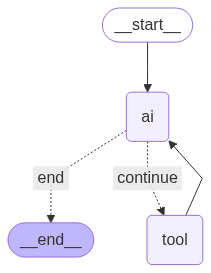

In [64]:
from IPython.display import Image , display 
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:

inputs = {"messages": [HumanMessage(content="hey , please email swathips1128@gmail.com and write the mail a harsh telling how much you missed her and u are looking forward for the movie date today and hopefully see her soon also use emoji in the text and wirte ina informal way")]}
result = app.invoke(inputs, config={"recursion_limit": 50})
print(result)

Connecting to Gmail...
Logging in...
Sending email...
Email sent successfully!
{'messages': [HumanMessage(content='hey , please email swathips1128@gmail.com and write the mail a harsh telling how much you missed her and u are looking forward for the movie date today and hopefully see her soon also use emoji in the text and wirte ina informal way', additional_kwargs={}, response_metadata={}, id='b7c9f831-3452-4c16-9a14-a1f443f34437'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'wcmctd5pr', 'function': {'arguments': '{"body":"Hey sweetheart 😘, I\'m missing you so much!! 🤗 I was just thinking about you and I couldn\'t wait for our movie date today 🍿👍. I\'m really looking forward to seeing you soon 🕰️ and spending some quality time together 💕. Hopefully, everything goes as planned and we can have an amazing time 🤞. Can\'t wait to see your smile 😊 and give you a big hug 🤗. See you soon!! 🚪💨","subject":"Missing you so much!! 🤗","to_email":"swathips1128@gmail.com"}', 'name